In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [31]:
import pandas as pd
from pandas import DataFrame, Series
#adding graphics
import matplotlib.pyplot as plt
%pylab inline
from pylab import rcParams
from collections import defaultdict
from collections import OrderedDict as od
rcParams['figure.figsize'] = 18, 6

#from IPython.html import widgets 
import ipywidgets as widgets
from IPython.display import display

###################################

all_lic = pd.read_table('ready_data.csv', sep=',') 
print all_lic

#fix the dates
def addyear(x):
    if x is nan :
        return nan
    ystr = x[6]+x[7]
    if (ystr>'18') :
        ystr = '19'+ystr
    else :
        ystr = '20'+ystr
    return ystr

def getarea(po) :
    area = po[:3]
    return area
# get rid of nulls in postal codes
all_lic= all_lic[pd.notnull(all_lic['Licence Address Line 3'])]
all_lic['year_issued']=all_lic["Issued"].map(addyear)
all_lic['year_cancel']=all_lic["Cancel Date"].map(addyear)


all_lic['area']=all_lic['postal'].map(getarea)
#print all_lic
###############################
cat = all_lic['Category']
d = defaultdict(int)
for c in cat :   
    d[c]+=1
df = DataFrame(d.items(),columns=['category','count'])
indf = df.set_index(['category'])
indf=indf.sort_index()
#####################################
def limit_year(dataset,yearfield,start=None,end=None,year=None) :
    target = dataset
    if (start is not None):
#        print " filtering for start year " + start
        target= target [target[yearfield]>= start]
    if (end is not None) :
#        print " filtering for end year " + end
        target = target[target[yearfield]<= end]
    if (year is not None) :
#        print " filtering for  year " + year
        target = target[target[yearfield]== year]
    return target

# here we build the weights of each area
def getweighted(dataset) :
    target = dataset
    areadict = defaultdict(int)
    for c in dataset['area'] :   
        areadict[c]+=1
    f = lambda x : areadict[x]
    target['w'] = target['area'].map(f)
    return target

# function gets total of a category through years in a single dataset
def get_totals_by(dataset,cat) :
    d = defaultdict(int)
    catseries=dataset[cat]
    for c in catseries :   
        if c is not nan :
            d[c]+=1
    df = DataFrame(d.items(),columns=[cat,'count'])
    indf = df.set_index([cat])
    indf= indf.sort_index()
    return indf

def limit_by_area (dataset,area) :
    target = dataset[dataset['area']==area]
    return target

def get_category(cat):
    cat_target= all_lic [all_lic['Category']==cat]
    return cat_target
################################################
year_rest = limit_year(get_category(cat='EATING ESTABLISHMENT'),year='2012',yearfield='year_issued')


year_w = getweighted(year_rest)

#ignore errors
year_w=year_w[year_w['lat']!=0]

year_w_heatdata= year_w[['lat','lng','w']]
heatmapdata= year_w_heatdata.to_records(index=False)


Populating the interactive namespace from numpy and matplotlib
        Unnamed: 0    Issued Cancel Date                    Operating Name  \
0                0  24/03/95    01/05/97                      EMERALD TAXI   
1                1  24/06/96    20/05/97                      PREMIER TAXI   
2                2  17/08/95    31/12/97                    A TORONTO TAXI   
3                3  03/03/88    08/06/98                       KIPLING KAB   
4                4  14/07/94    08/06/98                      RAINBOW TAXI   
5                5  02/02/95    24/07/98                        CROWN TAXI   
6                6  20/09/95    31/12/98                                     
7                7  25/04/80    04/01/99              EAST-END/HOWARD TAXI   
8                8  23/10/97    12/01/99                        RAPID TAXI   
9                9  28/03/94    23/03/99                               NaN   
10              10  28/03/94    23/03/99                               NaN   
1

EATING ESTABLISHMENT
1998
2013
ALL
issued  (26552, 13)
canceled  (24325, 13)
Total for period =  2227


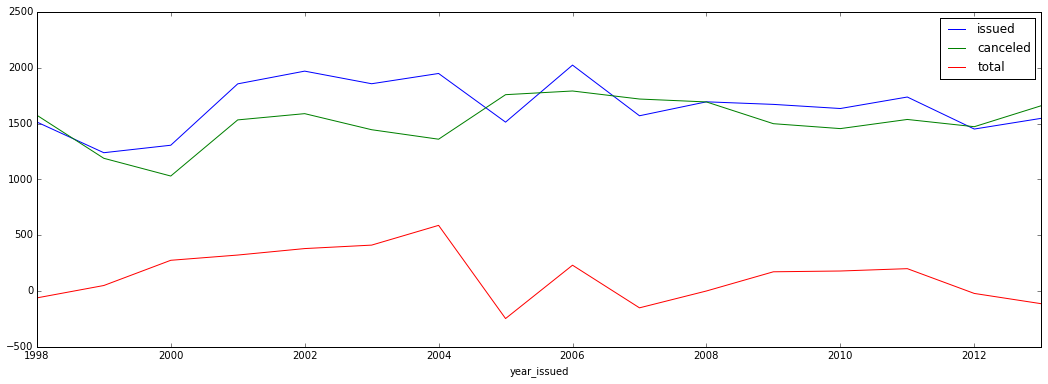

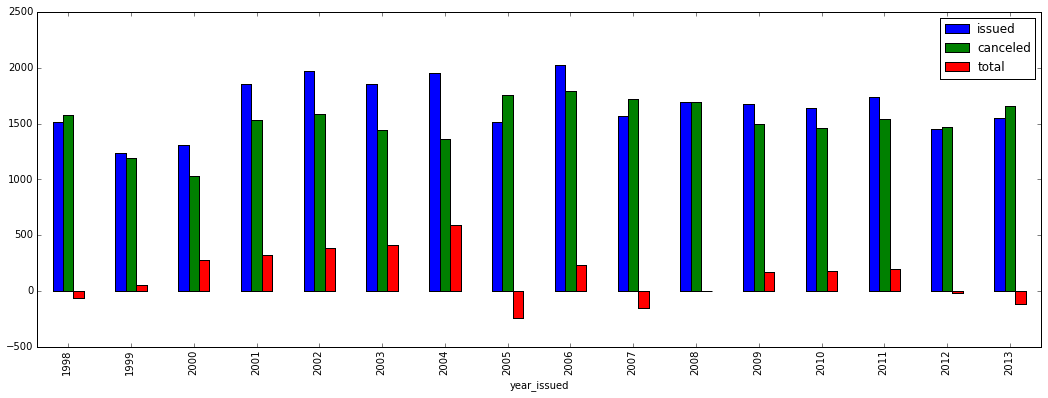

In [38]:
# Time to put an interface on this

def yearly_graph(category,starty,endy,postal,printme):
    print category
    print starty
    print endy
    print postal
    
    # first get the Year Issued  range
    if postal=="ALL" :
        issued_dataset = limit_year(get_category(cat=category),start=str(starty),end=str(endy),yearfield="year_issued")
        cancel_dataset = limit_year(get_category(cat=category),start=str(starty),end=str(endy),yearfield="year_cancel")
#        print dataset
    else :
        issued_dataset = limit_by_area(limit_year(get_category(cat=category),yearfield="year_issued",start=str(starty),end=str(endy)),postal)
        cancel_dataset = limit_by_area(limit_year(get_category(cat=category),yearfield="year_cancel",start=str(starty),end=str(endy)),postal)

    print "issued ", str (issued_dataset.shape)
    print "canceled ", str (cancel_dataset.shape)

    totalsissued = get_totals_by(issued_dataset,'year_issued')
    totalscanceled= get_totals_by(cancel_dataset,'year_cancel')
    
    final = pd.concat ([totalsissued,totalscanceled],axis=1)
    final.columns=['issued','canceled']
    final['total']=final['issued']-final['canceled']
    print "Total for period = ",final['total'].sum()
    final.plot()
    final.plot(kind='bar')
    if (printme) :
        print final
        print issued_dataset
        print cancel_dataset

catlist_w = widgets.Select()
catlist_w.options = list( indf.index)
catlist_w.label =" Category "

yearrange= range(1980,2016)
stryearrange =[str(i) for i in yearrange]


startyear_w = widgets.IntSlider(value=1980,min=1919,max=2015,step=1,description='Start YEAR !')
endyear_w = widgets.IntSlider(value=2015,min=1919,max=2015,step=1,description='End YEAR !')



postalfield = widgets.Text()
postalfield.label = "Postal Code"
postalfield.description = "Postal Code"
postalfield.value ="ALL"

print_data_w = widgets.ToggleButton(
    description='Print Data',
    value=False
)

start_range = widgets.IntSlider(min=1980,max=2015,step=1,description='STart YEAR !')

i = widgets.interact( yearly_graph,
                 category    = catlist_w, 
                 starty  = startyear_w,
                 endy = endyear_w,
                 postal = postalfield,
                 printme = print_data_w
             )
